In [2]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

In [3]:
# STLS
def transfer(long, short):
    cols = np.where(long != 0)[0]
    out = np.copy(long)
    for i, c in enumerate(cols):
        out[c] = short[i]
    return out

def convert(para):
    c = para[len(para)-1]
    for i in range(len(para)-1):
        c = transfer(para[len(para) - 2 - i], c)
    return c

In [4]:
# System
def system(c, one, x0, x1, x2, x3):
    return c[0]*one + c[1]*x0 + c[2]*x1 + c[3]*x2 + c[4]*x3 + \
           c[5]*x0**2 + c[6]*x1**2 + c[7]*x2**2 + c[8]*x3**2 + c[9]*x0*x1 + c[10]*x0*x2 + c[11]*x0*x3 + c[12]*x1*x2 + c[13]*x1*x3 + c[14]*x2*x3

n: 32 R2: -0.3022128035250429


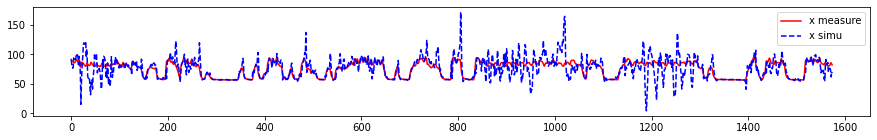

n: 64 R2: 0.9856965656326354


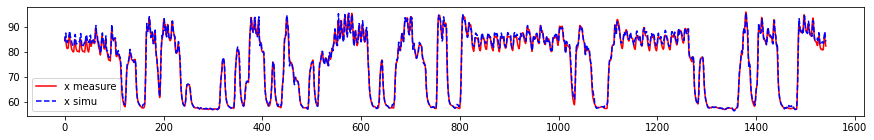

n: 128 R2: 0.9814668213316925


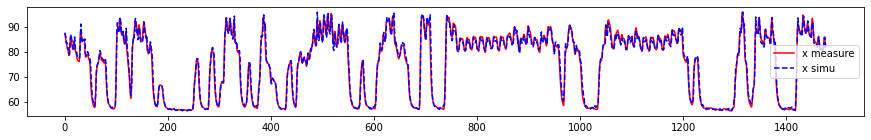

n: 256 R2: 0.9864802599958005


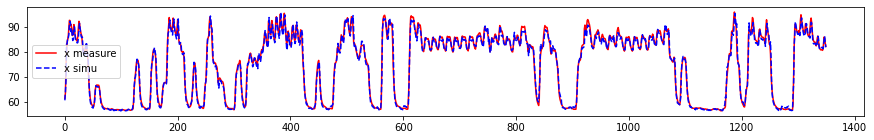

In [5]:
for n_train in [32, 64, 128, 256]:
    
    # DATA
    df = pd.read_csv('C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv')

    Tca = np.array(df['ahu_supply_temp']).reshape(-1,1)
    Tsa = np.array(df['supply_discharge_temp']).reshape(-1,1)
    qrh = np.array(df['htg_valve_position']).reshape(-1,1)

    Tca_k1 = Tca[1:n_train+1]
    Tsa_k  = Tsa[0:n_train]
    Tsa_k1 = Tsa[1:n_train+1]
    qrh_k2 = qrh[2:n_train+2]
    ones   = np.ones((n_train,1))

    y      = Tsa[2:n_train+2]

    x0     = np.copy(Tca_k1)
    x1     = np.copy(Tsa_k)
    x2     = np.copy(Tsa_k1)
    x3     = np.copy(qrh_k2)

    x02    = x0**2
    x12    = x1**2
    x22    = x2**2
    x32    = x3**2
    x0x1   = x0*x1
    x0x2   = x0*x2
    x0x3   = x0*x3
    x1x2   = x1*x2
    x1x3   = x1*x3
    x2x3   = x2*x3

    x0_t = Tca[n_train+1:-1]
    x1_t = Tsa[n_train:-2]
    x2_t = Tsa[n_train+1:-1]
    x3_t = qrh[n_train+2:]
    y_t  = Tsa[n_train+2:]
    ones_t = np.ones((Tca.shape[0]-n_train-2, 1))

    A = np.concatenate((ones, x0, x1, x2, x3, x02, x12, x22, x32, x0x1, x0x2, x0x3, x1x2, x1x3, x2x3), axis=1)
    b = np.copy(y)

    # SINDy with STLS
    alpha = 0.002
    para = ()
    A1 = np.copy(A)
    while(1):
        c = np.linalg.lstsq(A1, b, rcond=-1)[0]
        c = c*(np.abs(c)>alpha)
        para = para + (c,)

        cols = np.array([], dtype=np.int32)
        for i in range(c.shape[0]):
            if c[i] == 0:
                cols = np.append(cols, i)
        if(cols.shape[0] == 0):
            break
        A1 = np.delete(A1, cols, axis=1)
    
    c = convert(para)
    x_simu = system(c, ones_t, x0_t, x1_t, x2_t, x3_t)
    print("n:", n_train ,"R2:", r2_score(y_t, x_simu))

    # plot
    plt.figure(figsize=(15, 2))
    plt.plot(y_t,      'r-',  label='x measure')
    plt.plot(x_simu, 'b--', label='x simu')
    plt.legend()
    plt.show()
